## 6 Regularization (2) Dropout

In [0]:
%matplotlib inline
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
import shutil
import os
import time
from tqdm import tqdm

## 예제 데이터 ) 기술투자 비율과 예상 수익률 데이터 셋

기술 투자 비율과 예상 수익률에 대한 데이터셋입니다. <br>
아래와 같이 랜덤으로 50개의 데이터셋을 만들고, Test 데이터셋은 노이즈를 주지 않았습니다.<br>
데이터에 노이즈가 많고, 수가 적을 때 일반적으로 Overfitting이 발생하기 쉽습니다.

In [2]:
random_polynomial = lambda x : 3.5*x**3-4*x**2+x+0.5

train_invests = np.random.uniform(0.05,0.9, 50)
train_growths = np.array([random_polynomial(x)+np.random.normal(0,0.02) 
           for x in train_invests]) # 예상 수익률

train_invests = train_invests.reshape(-1,1) 
train_growths = train_growths.reshape(-1,1) 

test_invests = np.linspace(0.05,0.9,30)
test_growths = np.array([random_polynomial(x)
                         for x in test_invests])

test_invests = test_invests.reshape(-1,1)
test_growths = test_growths.reshape(-1,1)

print("train 데이터셋 크기 : {}".format(len(train_invests)))
print("test 데이터셋 크기 : {}".format(len(test_invests)))

train 데이터셋 크기 : 50
test 데이터셋 크기 : 30


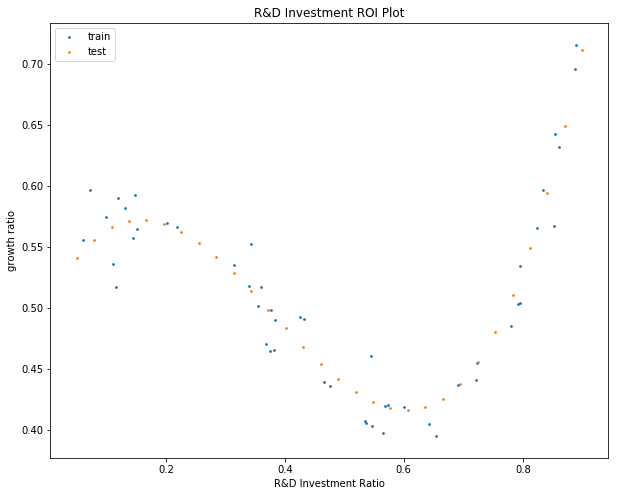

In [3]:
plt.figure(figsize=(10,8))
plt.scatter(train_invests, train_growths, s=3,label='train')
plt.scatter(test_invests, test_growths, s=3,label='test')
plt.title("R&D Investment ROI Plot")
plt.xlabel("R&D Investment Ratio")
plt.ylabel("growth ratio")
plt.legend()
plt.show()

## 문제 1. low level API로 Dropout 구현하기.

Tensorflow 을 이용해 Inverted Dropout 을 구현합니다.<br>
아래 모델이 Dropout을 통해 올바르게 동작하도록 구현해주세요.

#### 답안지 입력란
* 아래에 답을 서술하여 주세요
* `tf.layers.Dropout` 대신 dropout으로 동작하도록 구현해 주세요.

In [0]:
def dropout(tensor, training, drop_ratio):
    # FIX ME
    if is_train is True:
        mask = tf.random.binomial([np.ones(tensor.shape)], 1-drop_ratio)[0]
        out = mask * tensor * (1.0/(1-drop_ratio))
    else:
        out = tensor
    return out

#### 정답 확인
* 아래를 실행시키면 위로 구현된 dropout을 통해 모델이 학습됩니다.
* 모델이 안정적으로 학습되면 성공입니다.

W0801 00:24:37.900763 140008242546560 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1288: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


모델 구축하기---


W0801 00:24:38.220830 140008242546560 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


모델 학습하기---


100%|██████████| 20000/20000 [00:22<00:00, 870.21it/s]


모델 시각화하기---


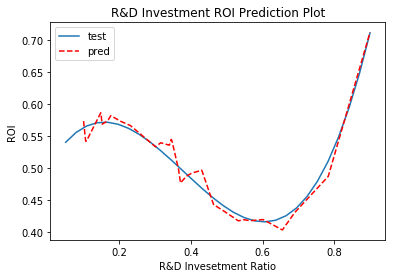

In [5]:
print("모델 구축하기---")
graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32, shape=(None,1),name='X')
    y = tf.placeholder(tf.float32, shape=(None,1),name='y')
    is_train = tf.placeholder_with_default(False, (),name='is_train')
    
    # Weight 초기화 함수
    he_init = tf.initializers.he_normal()
    xavier_init = tf.initializers.glorot_normal()
    
    # Graph 부분
    hidden_1 = tf.layers.Dense(100,
                               activation=tf.nn.relu,
                               kernel_initializer=he_init,
                               name="hidden_1")(X)
    dropout_1 = dropout(hidden_1,training=is_train,drop_ratio=0.4)
    hidden_2 = tf.layers.Dense(100,
                               activation=tf.nn.relu, 
                               kernel_initializer=he_init,
                               name='hidden_2')(dropout_1)
    dropout_2 = dropout(hidden_2,training=is_train,drop_ratio=0.4)
    y_pred = tf.layers.Dense(1,
                             kernel_initializer=xavier_init,
                             name='output')(dropout_2)
    
    # 손실 함수
    loss = tf.losses.mean_squared_error(y, y_pred)
    
    # training operation
    train_op = (tf.train
                .AdamOptimizer(learning_rate=0.01)
                .minimize(loss))
    
# 모델 학습
print("모델 학습하기---")
with tf.Session(graph=graph) as sess:
    # 가중치 초기화
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for epoch in tqdm(range(20000)):
        sess.run(train_op,feed_dict={X:train_invests,
                                     y:train_growths,
                                     is_train: True})
        
    # 0부터 1까지 순서대로 1000개를 출력
    test_xs = np.linspace(0.1,0.9,1000)
    test_xs = test_xs.reshape(-1,1)
    pred_ys = sess.run(y_pred, feed_dict={X:test_xs})    
    
print("모델 시각화하기---")    
plt.plot(test_invests, test_growths,label='test')
plt.plot(test_xs,pred_ys,'r--',label='pred')
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.legend()
plt.show()